# Disaster Tweets identification

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from string import punctuation
from collections import defaultdict
from nltk import FreqDist
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siddhartha_bhadra\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Import Dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


Visualisation of the data fetched before  progressing

Text(0, 0.5, 'samples')

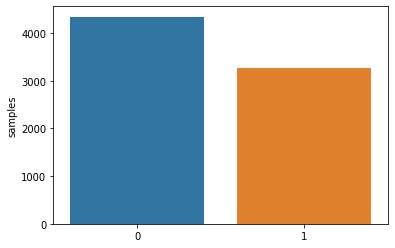

In [4]:
#Analyse the sample. How m any positive to disaster tweets are present compared to whole lot
x=df_train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

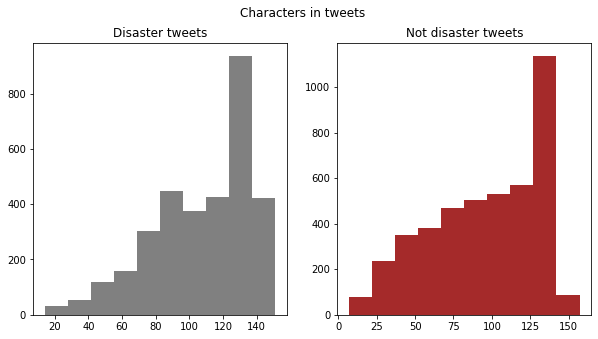

In [5]:
#Comparision of length of distater tweets vs the non disaster once
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweet_len = df_train[df_train['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='grey')
ax1.set_title('Disaster tweets')

tweet_len = df_train[df_train['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='brown')
ax2.set_title('Not disaster tweets')

fig.suptitle('Characters in tweets')
plt.show()

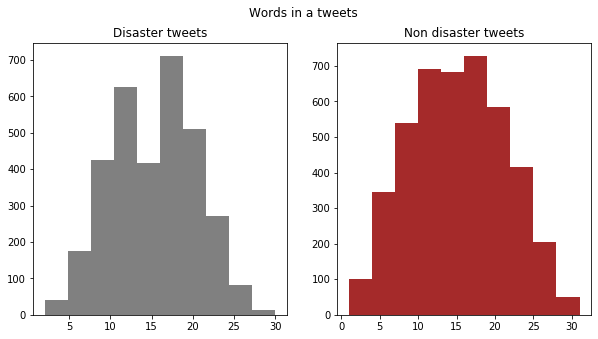

In [6]:
#Number of words in the disaster tweets vs the non disaster once
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
num_words = df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(num_words, color='grey')
ax1.set_title('Disaster tweets')

num_words = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(num_words, color='brown')
ax2.set_title('Non disaster tweets')

fig.suptitle('Words in a tweets')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

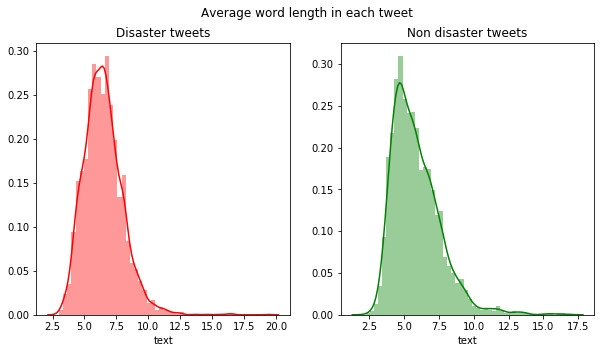

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
word = df_train[df_train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('Disaster tweets')

word = df_train[df_train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('Non disaster tweets')

fig.suptitle('Average word length in each tweet')

In [8]:
#covert tweets ints list of words
text_disaster = df_train[df_train['target']==1]['text'].str.split()
text_Nodisaster = df_train[df_train['target']==0]['text'].str.split()

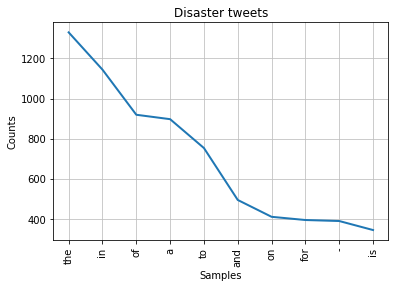

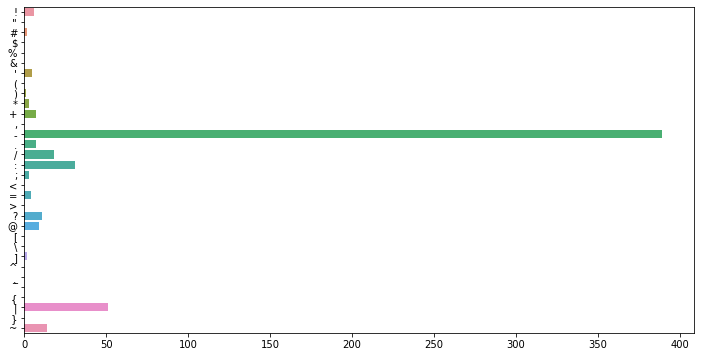

In [9]:
fdist = FreqDist(word.lower() for sentence in text_disaster for word in sentence)
fdist.plot(10, title="Disaster tweets")

dic=defaultdict(int)
punct = [fdist[p] for p in punctuation]
plt.figure(figsize=(12, 6))
sns.barplot(punct, list(punctuation))

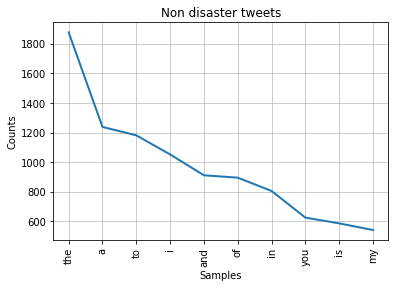

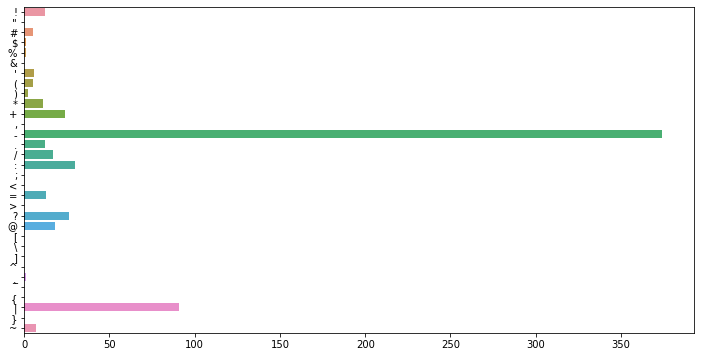

In [10]:
fdist = FreqDist(word.lower() for sentence in text_Nodisaster for word in sentence)
fdist.plot(10, title="Non disaster tweets")

dic=defaultdict(int)
punct = [fdist[p] for p in punctuation]
plt.figure(figsize=(12, 6))
sns.barplot(punct, list(punctuation))

In [11]:
#To get the most frequently used words in the bag . This mainly helps to develop the stopwords collection for this corpus
def get_top_tweet_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

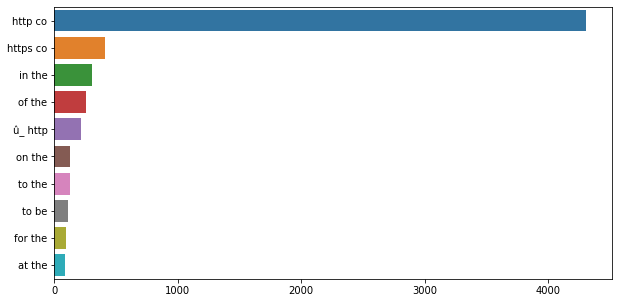

In [12]:
plt.figure(figsize=(10,5))
top_tweet_bigram = get_top_tweet_bigram(df_train['text'].tolist())[:10]
x,y = map(list, zip(*top_tweet_bigram))
sns.barplot(y,x)
#Hence we observe its mainly either URL Links or very common articles in english vocabulary

In [13]:
df_train = df_train.fillna('.')
df_test = df_test.fillna('.')

In [14]:
#Remove all URL's 
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [15]:
#Remove all emoji's in the text
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [16]:
#Remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [31]:
#Remove commonly used english words  eg like, is this etc that dont give any reference to what kind of text we are dealing with. 
#This is stem words. So stem commonly used words
def stem_words(text):
    tweet = text.lower()
    tweet = tweet.split()
    tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    return tweet

In [18]:

def preprocessing(re_URL=False, re_emoji=False, re_punct=False,re_stem = False):
    data_train = df_train['keyword'] +' '+ df_train['location'] +' '+ df_train['text']
    data_test = df_test['keyword'] +' '+ df_test['location'] +' '+ df_test['text']

    if re_URL:
        data_train = data_train.apply(lambda x : remove_URL(x))
        data_test = data_test.apply(lambda x : remove_URL(x))
        print("URL Removed")
    if re_emoji:
        data_train = data_train.apply(lambda x : remove_emoji(x))
        data_test = data_test.apply(lambda x : remove_emoji(x))
        print("Emoji Removed")
    if re_punct:
        data_train = data_train.apply(lambda x : remove_punct(x))     
        data_test = data_test.apply(lambda x : remove_punct(x))
        print("Punctuation Removed")
    if re_stem:
        data_train = data_train.apply(lambda x : stem_words(x))     
        data_test = data_test.apply(lambda x : stem_words(x))
        print("Stemming Done")
    return data_train, data_test

In [20]:
#Final Model fitting to all the above functions
df_train['sums'] = df_train['keyword'] +' '+ df_train['location'] +' '+ df_train['text']
df_test['sums'] = df_test['keyword'] +' '+ df_test['location'] +' '+ df_test['text']

X_train = df_train['sums']
y_train = df_train['target']
X_fin_test = df_test['sums']

In [22]:
X_train.to_list()

['. . Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 '. . Forest fire near La Ronge Sask. Canada',
 ". . All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '. . 13,000 people receive #wildfires evacuation orders in California ',
 '. . Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '. . #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '. . #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 ". . I'm on top of the hill and I can see a fire in the woods...",
 ". . There's an emergency evacuation happening now in the building across the street",
 ". . I'm afraid that the tornado is coming to our area...",
 '. . Three people died from the heat wave so far',
 '. . Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN

In [34]:
#Now lets apply the above function to train and test
X, x_fin = preprocessing(re_URL=True, re_emoji=True, re_punct=True, re_stem = True)

URL Removed
Emoji Removed
Punctuation Removed
Stemming Done


In [44]:
#Split the data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size = 0.20, random_state = 0)


In [45]:
def fit_and_predict(vec, clf, X_train, y_train,X_test,y_test):
    pipe = make_pipeline(vec, clf)
    pipe.fit(X_train, y_train)
    
    acc = pipe.score(X_test, y_test)
    print("Accuracy: ", acc)

In [46]:
#Now fit to different models and check
vec = CountVectorizer(ngram_range=(1,2))
clf = LogisticRegression()
fit_and_predict(vec, clf, X_train, y_train,X_test,y_test)

Accuracy:  0.8010505581089954


In [55]:
#With Naive bayes
from sklearn.naive_bayes import GaussianNB
vec = CountVectorizer(ngram_range=(1,2))
X_NB = vec.fit_transform(X).toarray()
X_train_NB, X_test_NB, y_train_NB, y_test_NB = train_test_split(X_NB, df_train['target'], test_size = 0.20, random_state = 0)
clf = GaussianNB()
clf.fit(X_train_NB, y_train_NB)

# Predicting the Test set results
y_pred_NB = clf.predict(X_test_NB)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_NB, y_pred_NB)

In [56]:
cm

array([[530, 356],
       [164, 473]], dtype=int64)

In [57]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_NB,y = y_train_NB, cv = 10)
print('Accuracy(Mean) :',accuracies.mean())
print('Accuracy(Std) :',accuracies.std())

Accuracy(Mean) : 0.6541871921182266
Accuracy(Std) : 0.016423644991855463
